### Importar bibliotecas

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults

### Carregar dados

In [2]:
# Carregar dados do CPU
machine = 'm_3330.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


###  Separar treino e teste

In [3]:
# Separar conjunto de treino e de teste dos dadas de CPU
test_perc = 1/(len(workload)//60)
test_len = int(len(workload)*test_perc)
str_test_perc = f'{test_len/len(workload):0.2f}'
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]

### Modelo ARIMA

In [4]:
# modelo ARIMA
order=(1,0,0)
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     27.069021
ar.L1      0.709244
sigma2    21.814907
dtype: float64

### Seleção dos melhores parâmetros
O método ARIMA(p,d,q) recebe 3 parâmetros que representam:
- p: componente autoregressivo
- d: diferença (usado quando a série não é estacionária)
- q: componente de média móvel

O script abaixo cria diversos modelos, com parâmetors distintos e apresenta ao final a melhor ordem (conjunto de parâmetros) do modelo que obteve o menor erro

In [5]:
# define alguns valores limites a serem testados 
# neste caso a diferença (d) será zero, pois a série é estacionária
max_p, max_d, max_q = 12, 0, 5

# cria uma lista com todas as combinações possíveis destes parâmetros, observando os limites definidos acima
orders = []
for p in range(max_p+1):
    for d in range(max_d+1):
        for q in range(max_q+1):
            orders.append((p,d,q))

# valida cada modelo
errors = []
for order in orders:
    model_name = f'saved_models/arima_{str_test_perc.replace(".","")}_{"".join(map(str, order))}_{machine.replace(".csv", "")}.pkl'
    if not os.path.isfile(model_name):
        # cria e salva um modelo caso não exista
        model_train = ARIMA(train_set, order=order).fit()
        model_test = ARIMA(test_set, order=order, enforce_stationarity=False).fit(model_train.params)
        model_test.save(model_name)
        print(f"Modelo salvo em: '{model_name}' ")
    else:
        # carrega um modelo salvo
        model_test = ARIMAResults.load(model_name)
        
    # guarda os erros de cada modelo em uma lista
    predict_set = model_test.predict().shift(-1)[:-1]
    error = mse(test_set[:-1], predict_set)
    errors.append(error)
    print(order, error, end = ' | ')

# identifica a melhor ordem (p,d,q) que apresentou o menor erro
best_order = None
for order, error in zip(orders, errors):
    best_error = min(errors)
    best_order = order if error == best_error else best_order
print(f'\n\nMelhor resultado:\n\tordem: {best_order}\n\terro: {best_error}')

Modelo salvo em: 'saved_models/arima_001_000_m_3330.pkl' 
(0, 0, 0) 44.62740650682421 | Modelo salvo em: 'saved_models/arima_001_001_m_3330.pkl' 
(0, 0, 1) 17.871684815520705 | Modelo salvo em: 'saved_models/arima_001_002_m_3330.pkl' 
(0, 0, 2) 12.463217316201426 | Modelo salvo em: 'saved_models/arima_001_003_m_3330.pkl' 
(0, 0, 3) 14.119681951296501 | Modelo salvo em: 'saved_models/arima_001_004_m_3330.pkl' 
(0, 0, 4) 16.006188175043256 | Modelo salvo em: 'saved_models/arima_001_005_m_3330.pkl' 
(0, 0, 5) 16.07814935655427 | Modelo salvo em: 'saved_models/arima_001_100_m_3330.pkl' 
(1, 0, 0) 3.5204643582174464 | Modelo salvo em: 'saved_models/arima_001_101_m_3330.pkl' 
(1, 0, 1) 3.6784743309313694 | Modelo salvo em: 'saved_models/arima_001_102_m_3330.pkl' 
(1, 0, 2) 4.572959460324701 | Modelo salvo em: 'saved_models/arima_001_103_m_3330.pkl' 
(1, 0, 3) 5.662176428748471 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_104_m_3330.pkl' 
(1, 0, 4) 5.039102230506431 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_105_m_3330.pkl' 
(1, 0, 5) 3.858007635556763 | Modelo salvo em: 'saved_models/arima_001_200_m_3330.pkl' 
(2, 0, 0) 3.5189058854640107 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_201_m_3330.pkl' 
(2, 0, 1) 288.3297939649735 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_202_m_3330.pkl' 
(2, 0, 2) 6.459484114988606 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_203_m_3330.pkl' 
(2, 0, 3) 6.482515181131793 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_204_m_3330.pkl' 
(2, 0, 4) 5.749290192808222 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_205_m_3330.pkl' 
(2, 0, 5) 4.639068786306645 | Modelo salvo em: 'saved_models/arima_001_300_m_3330.pkl' 
(3, 0, 0) 3.7061186469248093 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_301_m_3330.pkl' 
(3, 0, 1) 28.58907858209442 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_302_m_3330.pkl' 
(3, 0, 2) 5.667380325046658 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_303_m_3330.pkl' 
(3, 0, 3) 5.27026045111662 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_304_m_3330.pkl' 
(3, 0, 4) 6.987506734342403 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_305_m_3330.pkl' 
(3, 0, 5) 8.25016718581395 | Modelo salvo em: 'saved_models/arima_001_400_m_3330.pkl' 
(4, 0, 0) 5.29194074479525 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_401_m_3330.pkl' 
(4, 0, 1) 6.651343961822739 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_402_m_3330.pkl' 
(4, 0, 2) 25.61348339866858 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_403_m_3330.pkl' 
(4, 0, 3) 6.603250640680379 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_404_m_3330.pkl' 
(4, 0, 4) 8.4090856246482 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_405_m_3330.pkl' 
(4, 0, 5) 17.758410086596506 | Modelo salvo em: 'saved_models/arima_001_500_m_3330.pkl' 
(5, 0, 0) 3.050658086698361 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_501_m_3330.pkl' 
(5, 0, 1) 6.653441924101881 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_502_m_3330.pkl' 
(5, 0, 2) 9.866658639626774 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_503_m_3330.pkl' 
(5, 0, 3) 8.274939991210177 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_504_m_3330.pkl' 
(5, 0, 4) 10.50508720411035 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_505_m_3330.pkl' 
(5, 0, 5) 11.089868121570365 | Modelo salvo em: 'saved_models/arima_001_600_m_3330.pkl' 
(6, 0, 0) 4.566026150454914 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_601_m_3330.pkl' 
(6, 0, 1) 7.941159304216053 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_602_m_3330.pkl' 
(6, 0, 2) 11.1924932431373 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_603_m_3330.pkl' 
(6, 0, 3) 17.961282902911837 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_604_m_3330.pkl' 
(6, 0, 4) 7.74395257663505 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_605_m_3330.pkl' 
(6, 0, 5) 9.81806369363214 | Modelo salvo em: 'saved_models/arima_001_700_m_3330.pkl' 
(7, 0, 0) 4.759731363584988 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_701_m_3330.pkl' 
(7, 0, 1) 6.867470304136691 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_702_m_3330.pkl' 
(7, 0, 2) 10.68119500405483 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_703_m_3330.pkl' 
(7, 0, 3) 17.36721795054608 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_704_m_3330.pkl' 
(7, 0, 4) 23.76309570437742 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_705_m_3330.pkl' 
(7, 0, 5) 19.209024379736135 | Modelo salvo em: 'saved_models/arima_001_800_m_3330.pkl' 
(8, 0, 0) 3.6848925855428343 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_801_m_3330.pkl' 
(8, 0, 1) 8.553326390882699 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_802_m_3330.pkl' 
(8, 0, 2) 11.796728751787406 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_803_m_3330.pkl' 
(8, 0, 3) 17.475627440161517 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_804_m_3330.pkl' 
(8, 0, 4) 23.737535848723482 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_805_m_3330.pkl' 
(8, 0, 5) 15.00183410670632 | Modelo salvo em: 'saved_models/arima_001_900_m_3330.pkl' 
(9, 0, 0) 3.867229680124116 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_901_m_3330.pkl' 
(9, 0, 1) 8.146024028373676 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_902_m_3330.pkl' 
(9, 0, 2) 12.10207610550129 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_903_m_3330.pkl' 
(9, 0, 3) 16.304194060084537 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_904_m_3330.pkl' 
(9, 0, 4) 20.52233296921095 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_905_m_3330.pkl' 
(9, 0, 5) 15.477510451291371 | Modelo salvo em: 'saved_models/arima_001_1000_m_3330.pkl' 
(10, 0, 0) 5.194473975225097 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1001_m_3330.pkl' 
(10, 0, 1) 8.310515399144627 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1002_m_3330.pkl' 
(10, 0, 2) 10.223742162486875 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1003_m_3330.pkl' 
(10, 0, 3) 18.755516990157513 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1004_m_3330.pkl' 
(10, 0, 4) 54.482429491418856 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1005_m_3330.pkl' 
(10, 0, 5) 11.038551677694468 | Modelo salvo em: 'saved_models/arima_001_1100_m_3330.pkl' 
(11, 0, 0) 5.195365526962177 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1101_m_3330.pkl' 
(11, 0, 1) 8.304294344438084 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1102_m_3330.pkl' 
(11, 0, 2) 8.992444814371616 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1103_m_3330.pkl' 
(11, 0, 3) 18.293098802389476 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1104_m_3330.pkl' 
(11, 0, 4) 19.86896028814706 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1105_m_3330.pkl' 
(11, 0, 5) 36.89630913687241 | Modelo salvo em: 'saved_models/arima_001_1200_m_3330.pkl' 
(12, 0, 0) 5.710342296148874 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1201_m_3330.pkl' 
(12, 0, 1) 8.375153808218657 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1202_m_3330.pkl' 
(12, 0, 2) 9.896615194125895 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1203_m_3330.pkl' 
(12, 0, 3) 18.496683840619287 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1204_m_3330.pkl' 
(12, 0, 4) 24.75062847872652 | 

/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Modelo salvo em: 'saved_models/arima_001_1205_m_3330.pkl' 
(12, 0, 5) 37.33616743244233 | 

Melhor resultado:
	ordem: (5, 0, 0)
	erro: 3.050658086698361


/home/gsort/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### Execução do modelo com os melhores parâmetros

In [6]:
# modelo ARIMA
order=best_order
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     27.045236
ar.L1      0.678264
ar.L2      0.062734
ar.L3     -0.001785
ar.L4     -0.053847
ar.L5      0.029947
sigma2    21.713977
dtype: float64

### Comparar previsão x teste

Text(0,0.5,'% cpu')

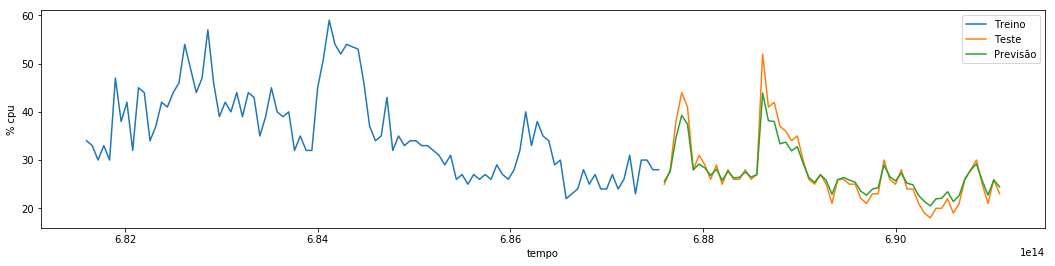

In [7]:
# compara a previsão com o conjunto de teste
predict_set = model_test.predict().shift(-1)[:-1]
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set[:-1])
plt.plot(predict_set)
plt.legend(['Treino', 'Teste', 'Previsão'])
plt.xlabel('tempo')
plt.ylabel('% cpu')

### Previsão de valores futuros

TypeError: invalid type promotion

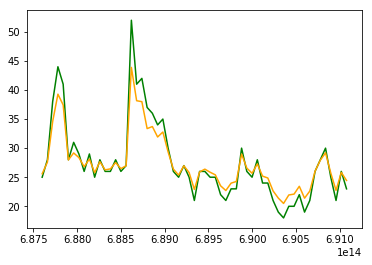

In [8]:
# Próximo passo
predict = model_test.forecast()
plt.figure(figsize=(6,4))
#plt.plot(train_set[-10:])
plt.plot(test_set[:-1], color='green')
plt.plot(predict_set, color='orange')
plt.scatter(predict.index, predict, color='red')
plt.text(predict.index, predict*1.035, f'{predict[0]:.2f}')
plt.legend(['Teste', 'Previsão', 'Previsão Futura'])
plt.xlabel('tempo')
plt.ylabel('% cpu')
predict

In [ ]:
# Conjunto de passos futuros
predict = model_test.forecast(steps=60)
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set[:-1])
plt.plot(predict_set)
plt.plot(predict)
plt.legend(['Treino', 'Teste', 'Previsão', 'Previsão Futura'])
plt.xlabel('tempo')
plt.ylabel('% cpu')

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [ ]:
mse(test_set[:-1], predict_set)